In [1]:
import pandas as pd
from pathlib import Path

# Read all CSV files from short_term_stats directory and concatenate them
all_files = Path("short_term_stats").glob("*.csv")
df_list = [pd.read_csv(f) for f in all_files]
df = pd.concat(df_list, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

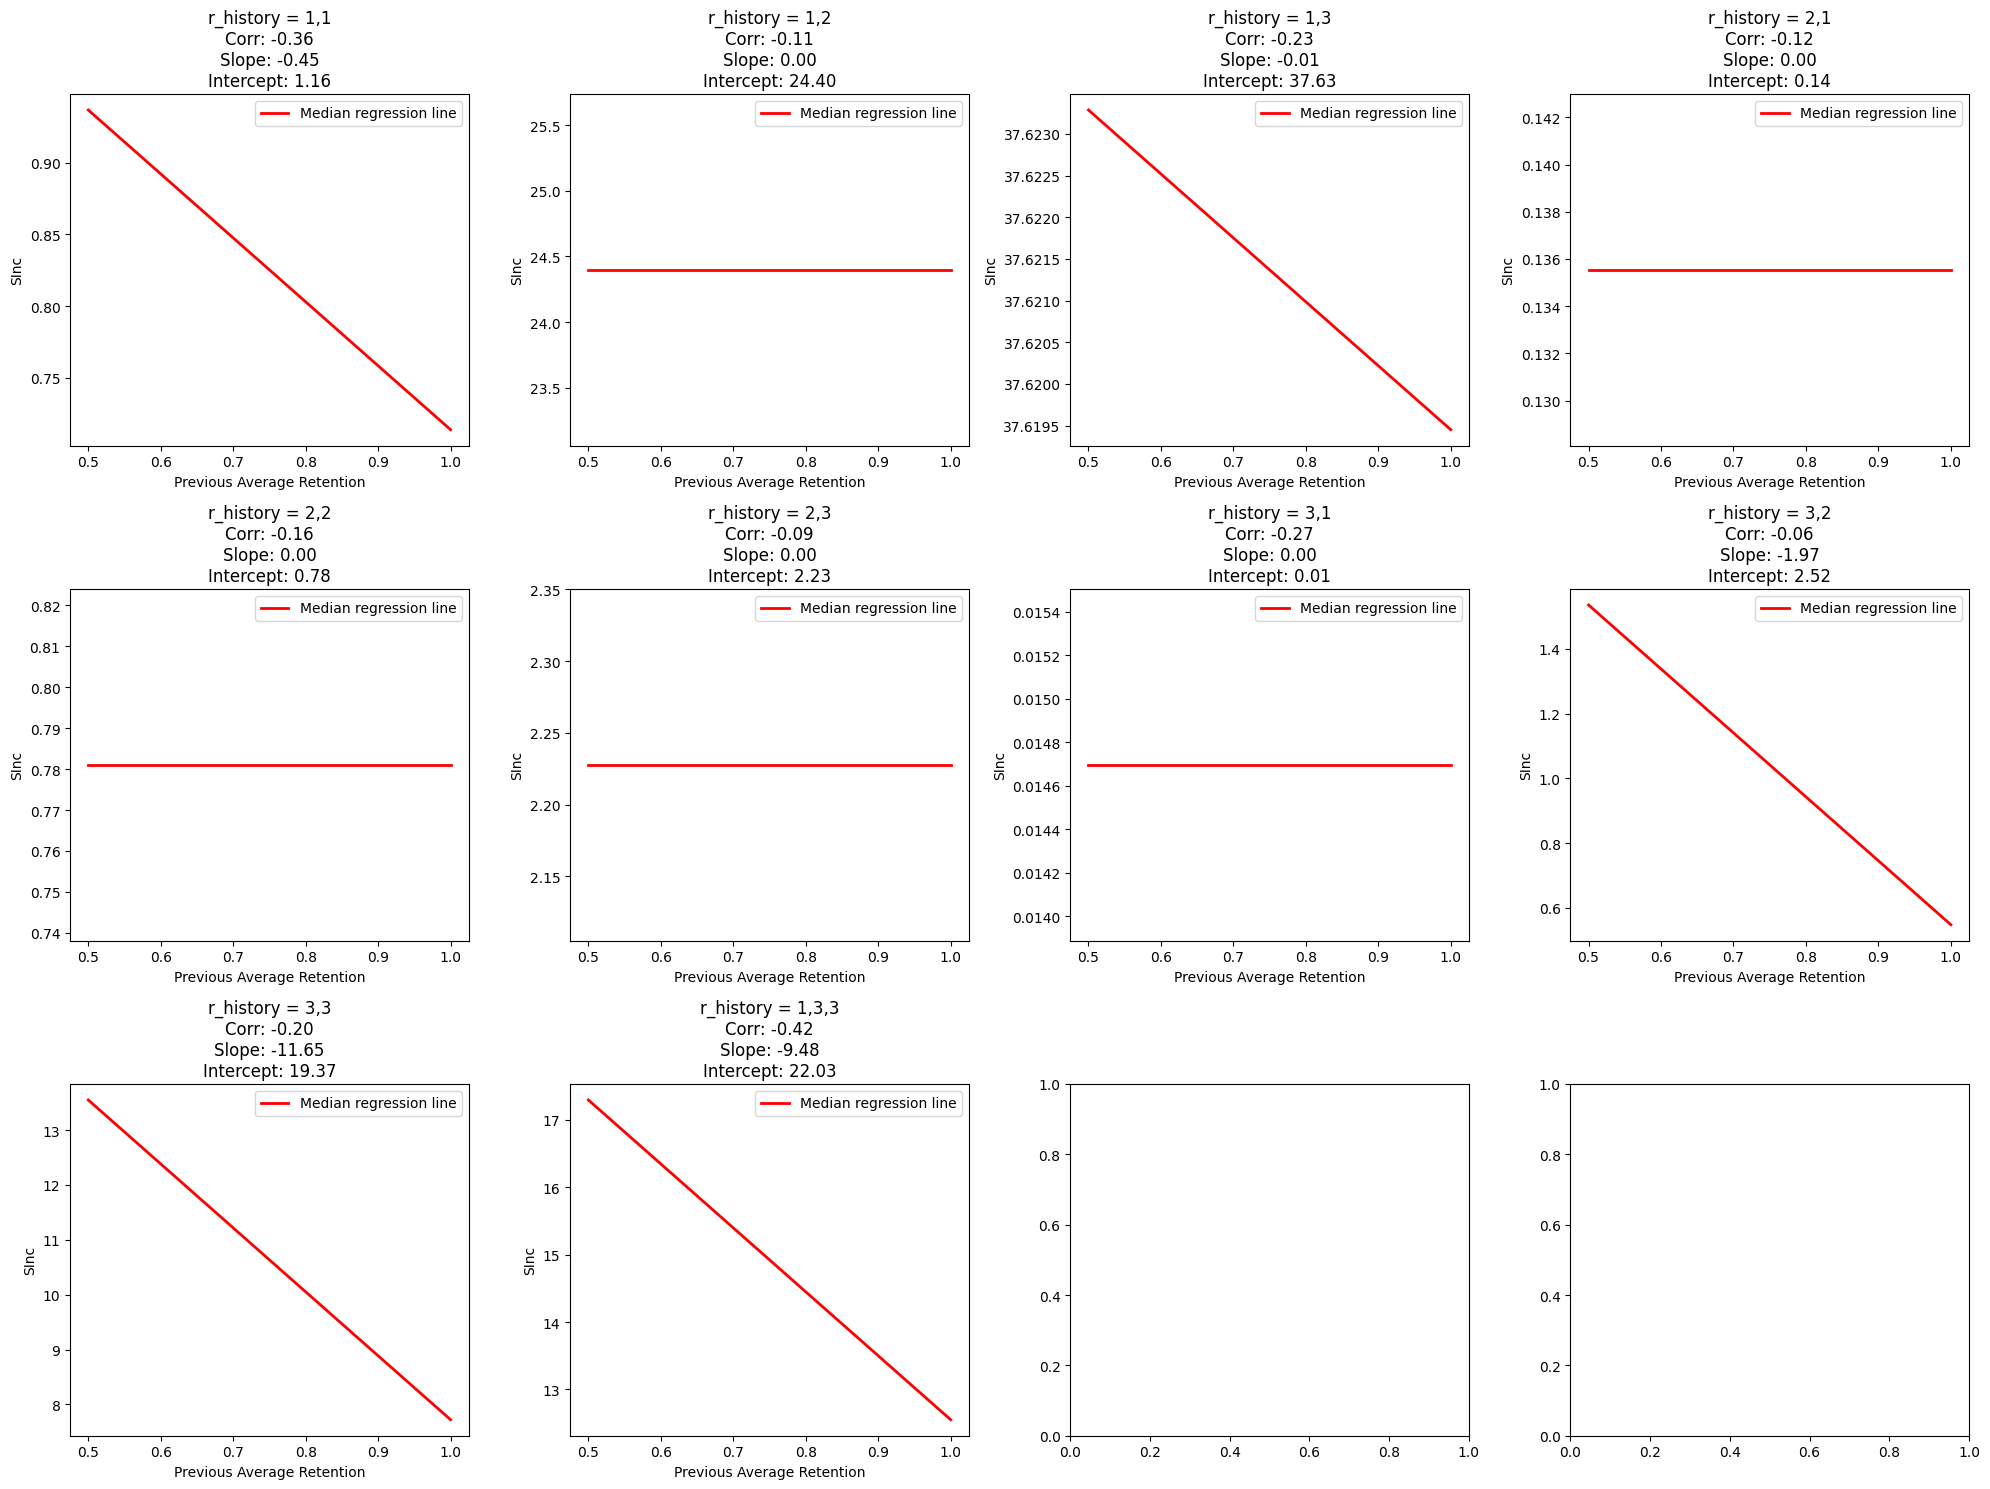

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from tqdm.auto import tqdm


r_history_list = [
    "1,1",
    "1,2",
    "1,3",
    "2,1",
    "2,2",
    "2,3",
    "3,1",
    "3,2",
    "3,3",
    "1,3,3",
]

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

# Store all slopes for return value
all_slopes = []

for idx, r_history in enumerate(tqdm(r_history_list)):
    # Initialize lists to store coefficients for this r_history
    intercepts = []
    slopes = []
    weights = []

    # Initialize weighted correlation calculation
    total_samples = 0
    weighted_corr_matrices = []

    # Iterate through all users
    for user_id in df["user_id"].unique():
        data = df[(df["user_id"] == user_id) & (df["r_history"] == r_history)]

        if len(data) < 2:  # Skip if not enough data points
            continue

        # Prepare X and y for linear regression
        X = data["prev_avg_retention"].values.reshape(-1, 1)
        y = data["SInc"].values
        sample_size = data["sample_size"].values

        # Fit linear regression
        reg = LinearRegression().fit(X, y, sample_weight=sample_size)

        intercepts.append(reg.intercept_)
        slopes.append(reg.coef_[0])
        weights.append(sample_size.sum())

        # Calculate correlation for this user
        corr_matrix = data[["prev_avg_retention", "SInc"]].corr()
        if not corr_matrix.isnull().any().any():
            weighted_corr_matrices.append((corr_matrix, sample_size.sum()))
            total_samples += sample_size.sum()

    if len(slopes) > 0:  # Only plot if we have data
        # Calculate averages
        # avg_intercept = np.average(intercepts, weights=weights)
        # avg_slope = np.average(slopes, weights=weights)
        median_intercept = np.median(intercepts)
        median_slope = np.median(slopes)
        all_slopes.extend(slopes)

        # Calculate weighted average correlation
        weighted_avg_corr = (
            sum(matrix * weight for matrix, weight in weighted_corr_matrices)
            / total_samples
            if total_samples > 0
            else 0
        )
        corr_value = weighted_avg_corr.iloc[
            0, 1
        ]  # Get correlation between prev_avg_retention and SInc

        # Plot average line
        x_range = np.linspace(0.5, 1, 100).reshape(-1, 1)
        y_pred = median_slope * x_range + median_intercept

        axes[idx].plot(
            x_range, y_pred, color="red", linewidth=2, label="Median regression line"
        )
        axes[idx].set_xlabel("Previous Average Retention")
        axes[idx].set_ylabel("SInc")
        axes[idx].set_title(
            f"r_history = {r_history}\nCorr: {corr_value:.2f}\nSlope: {median_slope:.2f}\nIntercept: {median_intercept:.2f}"
        )
        axes[idx].legend()

plt.tight_layout()
plt.show()

In [3]:

for r_history in r_history_list:
    print(f"\nCorrelations for r_history = {r_history}:")
    total_samples = 0
    weighted_corr_matrices = []
    for user_id in df["user_id"].unique():
        group_data = df[(df["user_id"] == user_id) & (df["r_history"] == r_history)]
        if group_data.empty:
            continue
        corr_matrix = group_data[
            ["prev_avg_interval", "prev_avg_retention", "SInc"]
        ].corr()

        if corr_matrix.isnull().any().any():
            continue
        
        # Weight by total sample size for this group
        group_samples = group_data['sample_size'].sum()
        weighted_corr_matrices.append((corr_matrix, group_samples))
        total_samples += group_samples

    # Calculate weighted average correlation matrix
    weighted_avg_corr = sum(
        matrix * weight for matrix, weight in weighted_corr_matrices
    ) / total_samples

    print(f"total samples: {total_samples}")
    print(weighted_avg_corr)


Correlations for r_history = 1,1:
total samples: 263341
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.651875  0.522667
prev_avg_retention          -0.651875            1.000000 -0.357753
SInc                         0.522667           -0.357753  1.000000

Correlations for r_history = 1,2:
total samples: 45014
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.527147  0.274065
prev_avg_retention          -0.527147            1.000000 -0.105085
SInc                         0.274065           -0.105085  1.000000

Correlations for r_history = 1,3:
total samples: 524253
                    prev_avg_interval  prev_avg_retention      SInc
prev_avg_interval            1.000000           -0.668843  0.366355
prev_avg_retention          -0.668843            1.000000 -0.230806
SInc                         0.366355           -0.230806  1.000000

Correlations 